# 1조 김도영
---
## <주제>  가위바위보 이미지 분류

### 자료 출처
- 케글 : https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
- <b>다수 교육생들의 손</b>

## CNN(Convolution Neural Network) : 합성곱신경망
---
- 이미지, 영상 처리에 사용되는 신경망 모델
- DNN의 한 분야
- 텍스트 처리에도 사용되는 모델
- 사용되는 Layer
    * ConvXD : 이미지의 형태 그대로 입력받아 특징을 추출하는 레이어
    * Pooling : 특징맵에서 특징을 다시 추출, 다운샘플링하는 레이어, 크기 반으로 줄임

## [1] 데이터 준비 및 로딩

In [1]:
# 모듈 로딩
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import platform
import random

In [2]:
# 한글 깨짐 방지
if platform.system()=='Windows':
    plt.rc('font',family='Malgun Gothic')
else:
    plt.rc('font',family='AppleGothic')

In [3]:
ga = os.listdir('data/가위')
ba = os.listdir('data/바위')
bo = os.listdir('data/보')

## [2] 데이터 전처리 및 학습형태로 변환

In [4]:
# 가위
ga_list=[]
for file in ga:
    im = plt.imread('data/가위/'+file)
    im = cv2.resize(im, (100, 100))
    ga_list.append(im)

In [5]:
# 바위
ba_list=[]
for file in ba:
    im = plt.imread('data/바위/'+file)
    im = cv2.resize(im, (100, 100))
    ba_list.append(im)

In [6]:
# 보
bo_list=[]
for file in bo:
    im = plt.imread('data/보/'+file)
    im = cv2.resize(im, (100, 100))
    bo_list.append(im)

In [7]:
# 하나의 데이터로 병합 <- numpy array 형태
ga1=np.concatenate(ga_list)
ba1=np.concatenate(ba_list)
bo1=np.concatenate(bo_list)

data=np.concatenate((ga1, ba1, bo1))

# Conv 레이어는 이미지의 채널 정보까지 입력
data = data.reshape(-1, 100, 100, 3)

In [8]:
# 타겟 숫자 부여
v1=np.zeros(len(ga_list))    # 가위 0
v2=np.ones(len(ba_list))     # 바위 1
v3=np.ones(len(bo_list))*2   #  보  2

target=np.concatenate((v1,v2,v3))

In [9]:
# Target => 문자 => 수치화
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [10]:
ohencoder=OneHotEncoder()
target=ohencoder.fit(target.reshape(-1,1)).transform(target.reshape(-1,1))

In [11]:
# 희소 행렬 -> numpy array 형변환
target = target.toarray()

In [12]:
print(f'data.shape : {data.shape},  target.shape : {target.shape}')

data.shape : (2188, 100, 100, 3),  target.shape : (2188, 3)


### 학습 데이터 테스트 데이터 분리

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    stratify=target,
                                                    random_state=42)

In [15]:
# 검증용 데이터 준비
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  random_state=42)

In [16]:
print(f'x_train.shape : {x_train.shape}\nx_test.shape : {x_test.shape}\nx_val.shape : {x_val.shape}')

x_train.shape : (1230, 100, 100, 3)
x_test.shape : (547, 100, 100, 3)
x_val.shape : (411, 100, 100, 3)


## [3] 모델 구성 및 생성
---
- 입력 형태 : 채널정보까지 포함 3차원 (100, 100, 3)
- 출력 형태 : 확률값 3개(가위, 바위, 보) 출력
- 학습 방식 : 분류 - 다중분류

In [17]:
# W,b 초기값 고정
set_random_seed(6)

In [18]:
def createCNNModel(filter):
    # 모델 객체 생성
    model=Sequential()
    # 이미지 특징 추출 Layer => 첫번째 입력값 설정
    model.add(Conv2D(filters=filter, kernel_size=3, padding='same', input_shape=(100,100,3)))
    # 이미지 특징 다운샘플링 Layer => MaxPool2D
    model.add(MaxPool2D())
    model.add(Conv2D(filters=filter, kernel_size=3, padding='same'))
    model.add(MaxPool2D())
    model.add(Conv2D(filters=filter, kernel_size=3, padding='same'))
    model.add(MaxPool2D())
    # 1차원으로 데이터 형태 변환 Layer => Flatten
    model.add(Flatten())
    # 출력층 => Node : 3개(가위,바위,보), activation : softmax
    model.add(Dense(units=3, activation='softmax'))
    # 모델 생성
    model.compile(loss='categorical_crossentropy',    # 오차 계산(손실) 함수 설정
                  optimizer='adam',                   # W,b 최적화 방식 설정
                  metrics='accuracy')                 # 모델의 성능 측정(평가) 항목 설정
    return model

In [19]:
models = createCNNModel(30)
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 30)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 30)        8130      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 30)       0

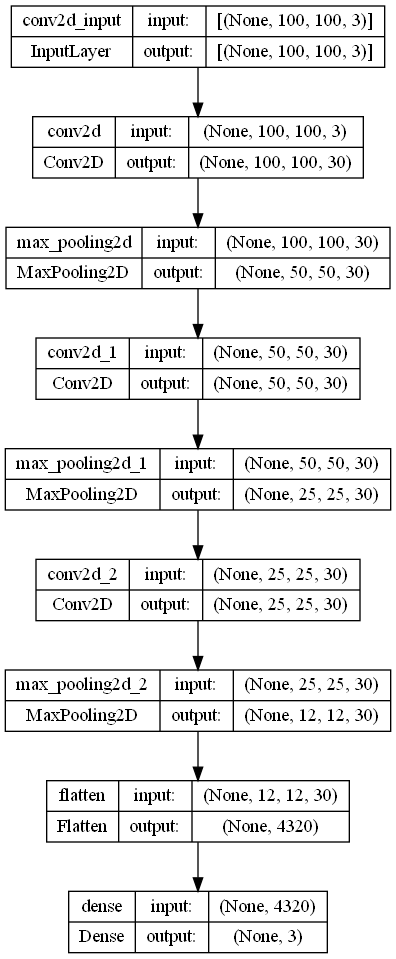

In [20]:
plot_model(models, show_shapes=True)

## [4] 모델 학습
---
- fit() 메서드
    * 학습 데이터, 라벨
    * epochs 학습횟수
    * batch_size 학습분량
    * validation_data (검증데이터, 검증라벨)
    * validation_split 학습데이터의 일부 비율 설정 (예:0.2)
    * callbacks
    * verbose 학습 진행도 화면 출력 여부 설정

In [21]:
# 검증 데이터에 대한 loss값 5번 연속 개선되지 않으면 학습 중지
stopCB = EarlyStopping(monitor='val_loss', patience=5)

In [22]:
his = models.fit(x_train, y_train, 
                 epochs=30,
                 batch_size=128,
                 validation_data=(x_val, y_val),
                 callbacks=[stopCB], verbose=0)

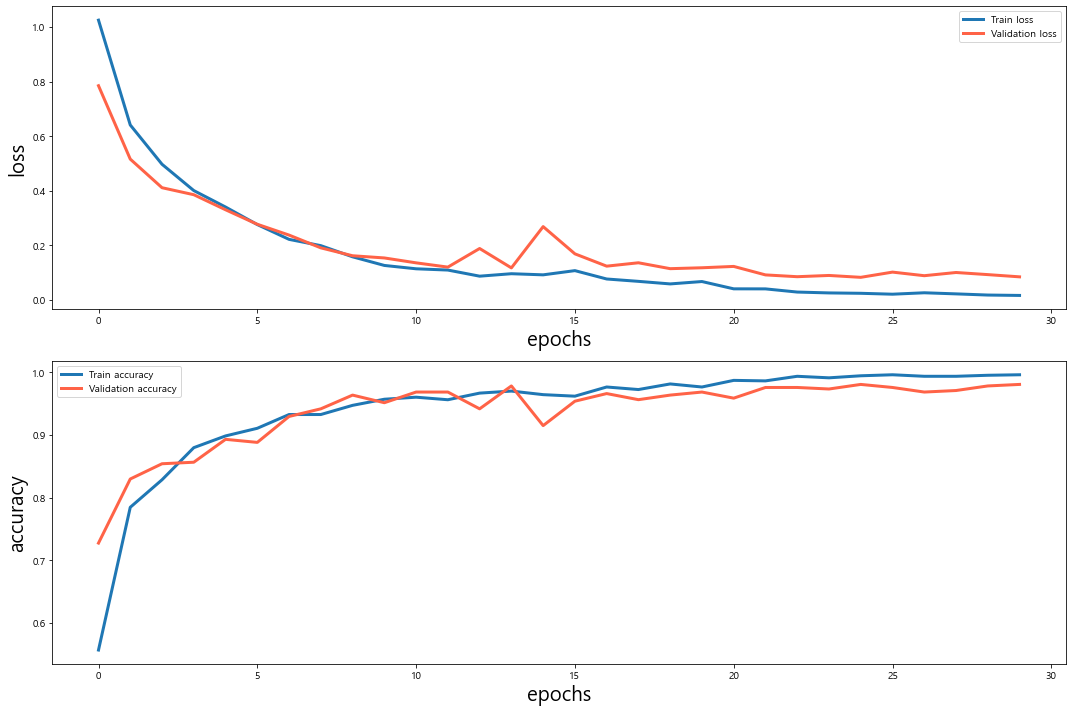

In [23]:
## loss, accuracy 시각화
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(his.epoch, his.history['loss'], label='Train loss', linewidth=3)
plt.plot(his.epoch, his.history['val_loss'], label='Validation loss', color='tomato', linewidth=3)
plt.xlabel('epochs', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.legend()

plt.subplot(212)
plt.plot(his.epoch, his.history['accuracy'], label='Train accuracy', linewidth=3)
plt.plot(his.epoch, his.history['val_accuracy'], label='Validation accuracy',color='tomato', linewidth=3)
plt.xlabel('epochs', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend()

plt.tight_layout()
plt.show()

## [5] 모델 평가
---
- evaluate() 메서드
- 반환값 : loss, compile()의 metrics에서 설정된 항목값

In [24]:
models.evaluate(x_test, y_test)

18/18 [==============================] - 1s 43ms/step - loss: 0.2383 - accuracy: 0.9616


[0.23833128809928894, 0.9616087675094604]

## [6] DNN모델 복원 및 평가

In [25]:
from tensorflow.keras.models import load_model

M_FILE='rspModel.h5'
W_FILE='rspWeight.h5'

reModel=load_model(M_FILE)

reModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3000100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 3)                 3

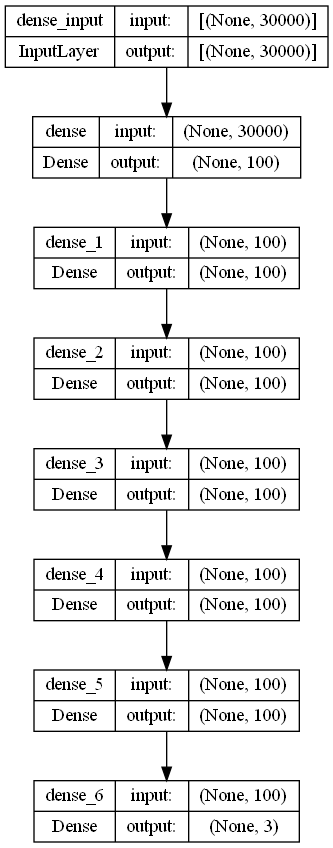

In [26]:
plot_model(reModel, show_shapes=True)

In [27]:
# DNN 모델 평가
reModel.evaluate(x_test.reshape(-1,30000), y_test)

18/18 [==============================] - 0s 5ms/step - loss: 0.1650 - accuracy: 0.9452


[0.16500814259052277, 0.9451553821563721]

## [7] 예측
---
- 새로운 데이터

실제값 : [[0. 0. 1.]] ◀ 보
예측값 : [[0. 0. 1.]] ◀ 보


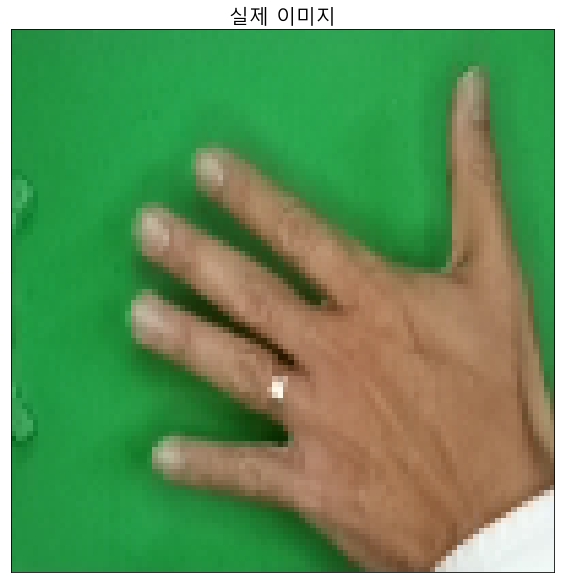

			▶ 예측 성공 !! ◀




실제값 : [[0. 1. 0.]] ◀ 바위
예측값 : [[0. 1. 0.]] ◀ 바위


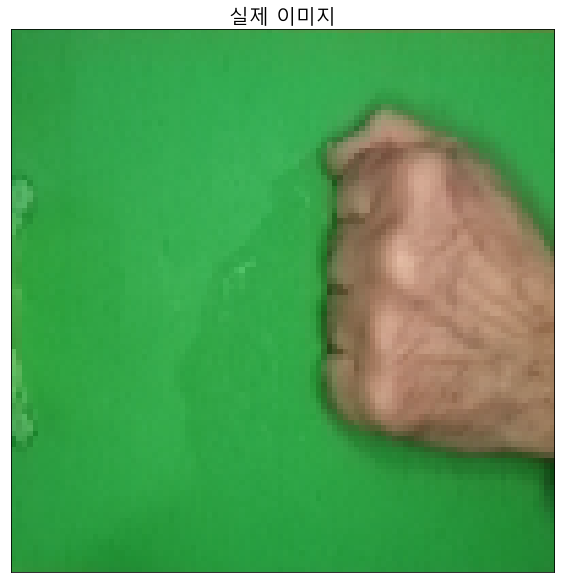

			▶ 예측 성공 !! ◀




실제값 : [[0. 1. 0.]] ◀ 바위
예측값 : [[0. 1. 0.]] ◀ 바위


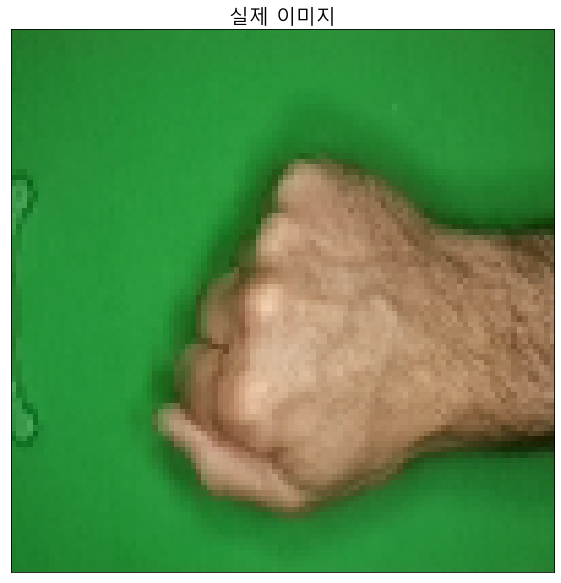

			▶ 예측 성공 !! ◀




실제값 : [[0. 0. 1.]] ◀ 보
예측값 : [[1. 0. 0.]] ◀ 가위


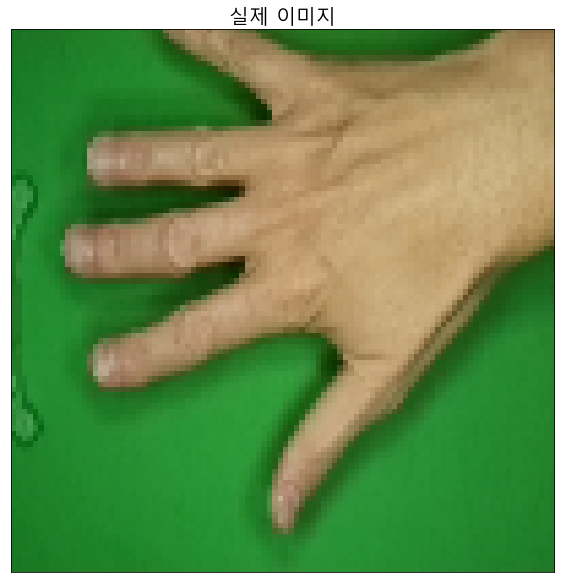

			▷ 예측 실패 !! ◁




실제값 : [[1. 0. 0.]] ◀ 가위
예측값 : [[1. 0. 0.]] ◀ 가위


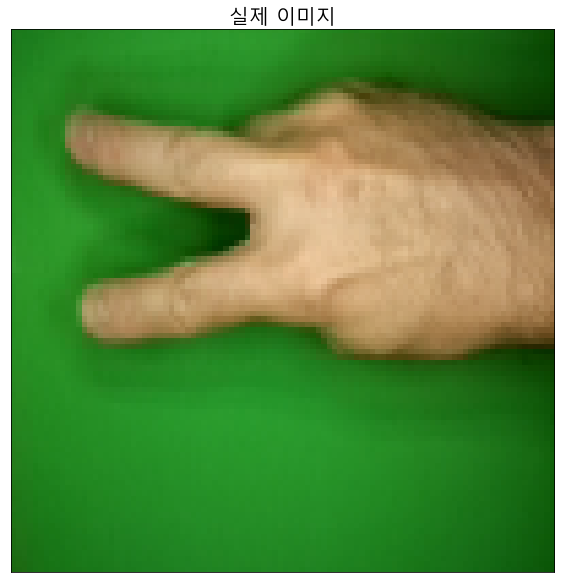

			▶ 예측 성공 !! ◀




실제값 : [[0. 1. 0.]] ◀ 바위
예측값 : [[0. 1. 0.]] ◀ 바위


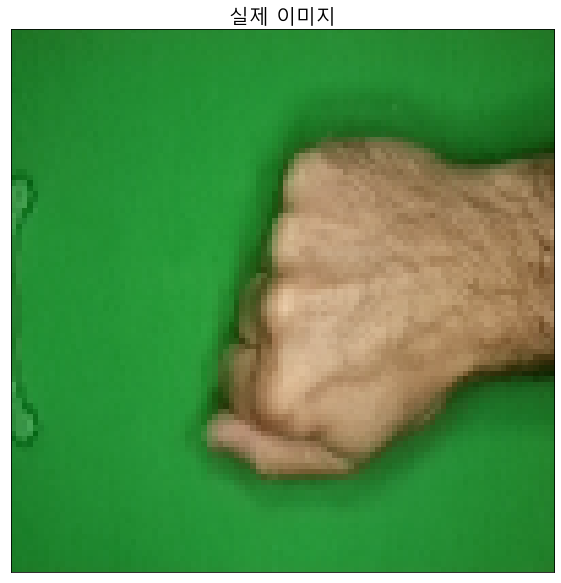

			▶ 예측 성공 !! ◀




실제값 : [[0. 0. 1.]] ◀ 보
예측값 : [[0. 0. 1.]] ◀ 보


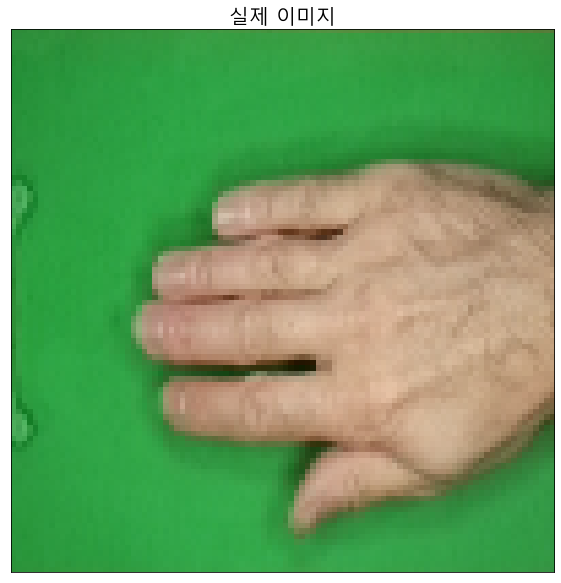

			▶ 예측 성공 !! ◀




실제값 : [[0. 1. 0.]] ◀ 바위
예측값 : [[0. 1. 0.]] ◀ 바위


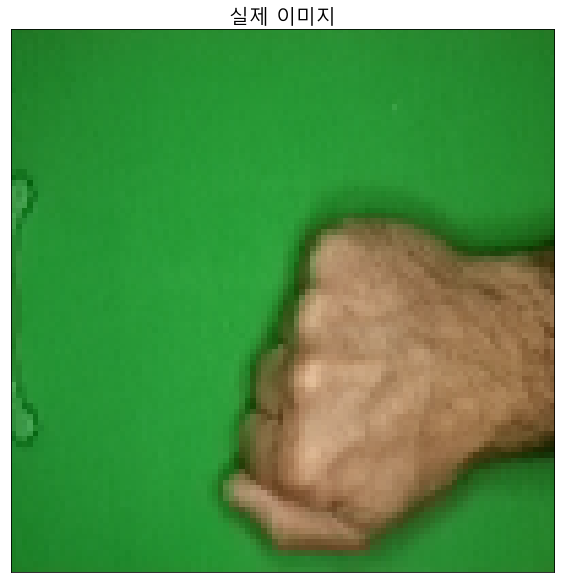

			▶ 예측 성공 !! ◀




실제값 : [[0. 0. 1.]] ◀ 보
예측값 : [[0. 0. 1.]] ◀ 보


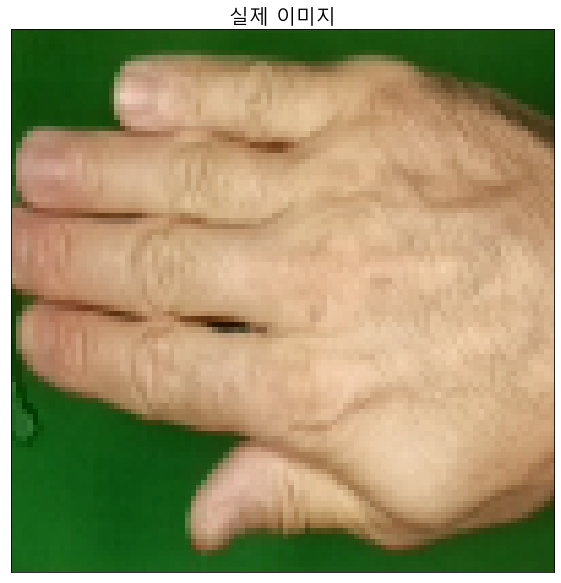

			▶ 예측 성공 !! ◀




실제값 : [[1. 0. 0.]] ◀ 가위
예측값 : [[1. 0. 0.]] ◀ 가위


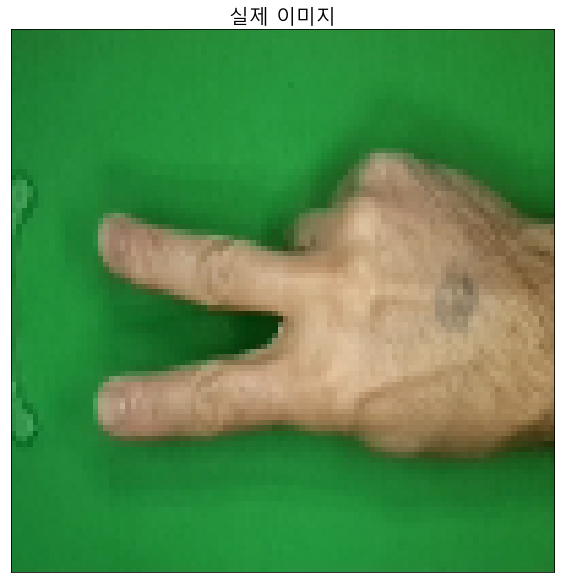

			▶ 예측 성공 !! ◀






In [28]:
for _ in range(10):
    label=['가위','바위','보']

    ran = random.randint(0,len(x_test)-1)   

    pre_out = models.predict(x_test[ran].reshape(-1, 100, 100, 3), verbose='Flase')

    # 실제값
    print(f'실제값 : [{y_test[ran]}] ◀ {label[y_test[ran].argmax()]}')

    # 예측값
    print(f'예측값 : {np.round(pre_out)} ◀ {label[pre_out.argmax()]}')

    # 실제 이미지
    plt.figure(figsize=(10,10))
    plt.title('실제 이미지', fontsize=20)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(x_test[ran].reshape(100,100,3))
    plt.show()

    if np.round(pre_out).argmax() == y_test[ran].argmax():
        print('\t\t\t▶ 예측 성공 !! ◀')
    elif np.round(pre_out).argmax() != y_test[ran].argmax():
        print('\t\t\t▷ 예측 실패 !! ◁')
    print()        
    print()
    print('='*100)
    print()
    print()

### 가위바위보 대결

실제값 : [[1. 0. 0.]] ◀ 가위
예측값 : [[1. 0. 0.]] ◀ 가위


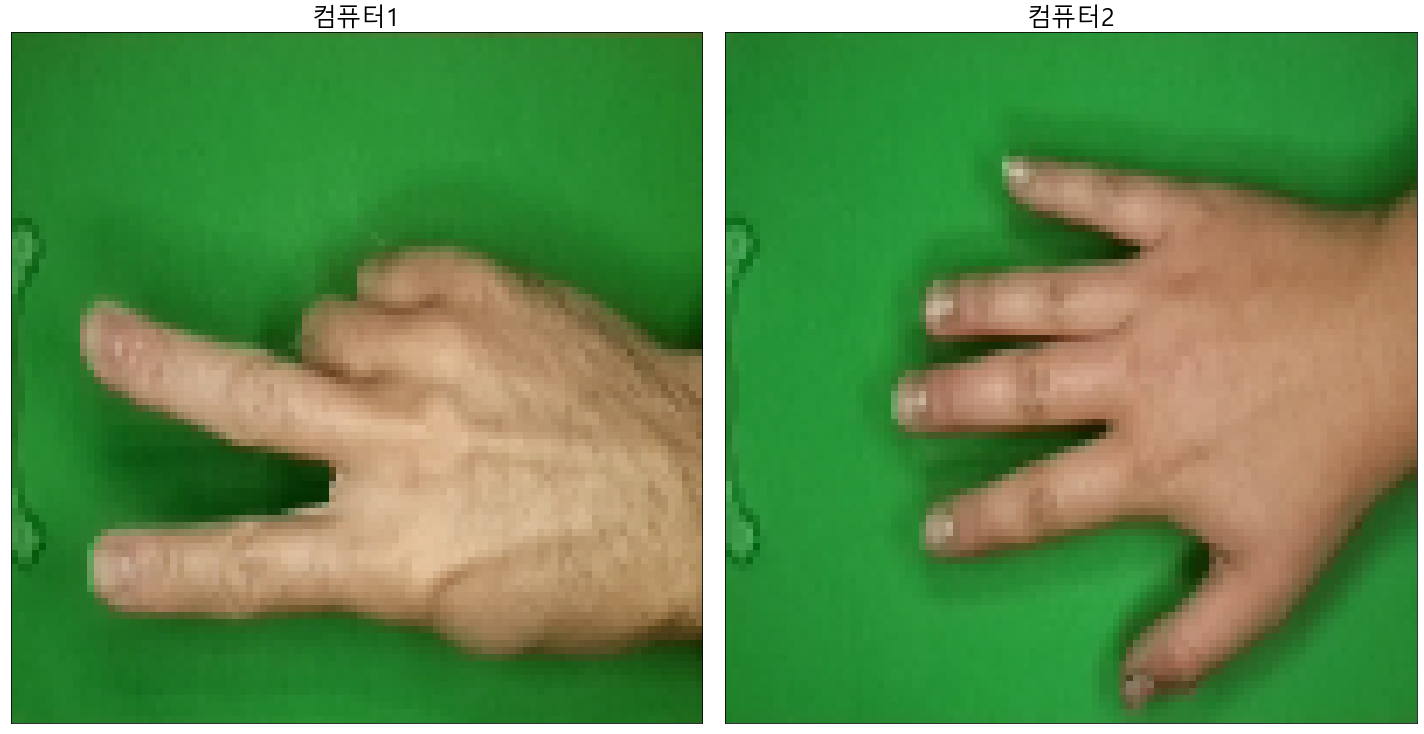

							▶ 컴퓨터1 승리 ◀


In [33]:
import random
# random.seed(42)
label=['가위','바위','보']

ran = random.randint(0,len(x_test)-1)
ran_1 = random.randint(0,len(x_val)-1)

pre_out = models.predict(x_test[ran].reshape(-1,100,100,3), verbose='Flase')

# 실제값
print(f'실제값 : [{y_test[ran]}] ◀ {label[y_test[ran].argmax()]}')

# 예측값
print(f'예측값 : {np.round(pre_out)} ◀ {label[pre_out.argmax()]}')

# 실제 이미지
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('컴퓨터1', fontsize=25)
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(x_test[ran].reshape(100,100,3))

# 새로운 이미지
plt.subplot(122)
plt.title('컴퓨터2', fontsize=25)
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(x_val[ran_1].reshape(100,100,3))

plt.tight_layout()
plt.show()

if (y_test[ran] == np.round(pre_out)).tolist() == [[True, True, True]]:
    if y_test[ran][0]==1:
        if (y_val[ran_1] == [1., 0., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 무승부 ◀')
        elif (y_val[ran_1] == [0., 1., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터2 승리 ◀')
        elif (y_val[ran_1] == [0., 0., 1.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터1 승리 ◀')

    elif y_test[ran][1]==1:
        if (y_val[ran_1] == [1., 0., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터1 승리 ◀')
        elif (y_val[ran_1] == [0., 1., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 무승부 ◀')
        elif (y_val[ran_1] == [0., 0., 1.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터2 승리 ◀')

    elif y_test[ran][2]==1:
        if (y_val[ran_1] == [1., 0., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터2 승리 ◀')
        elif (y_val[ran_1] == [0., 1., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터1 승리 ◀')
        elif (y_val[ran_1] == [0., 0., 1.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 무승부 ◀')
elif (y_test[ran] == np.round(pre_out)).tolist() != [[True, True, True]]:
    print('\t\t\t\t\t\t\t▷ 예측 실패 !! ◁')

In [34]:
# 파일명 불러오기
pre = os.listdir('pre/')
pre = pre[1:]

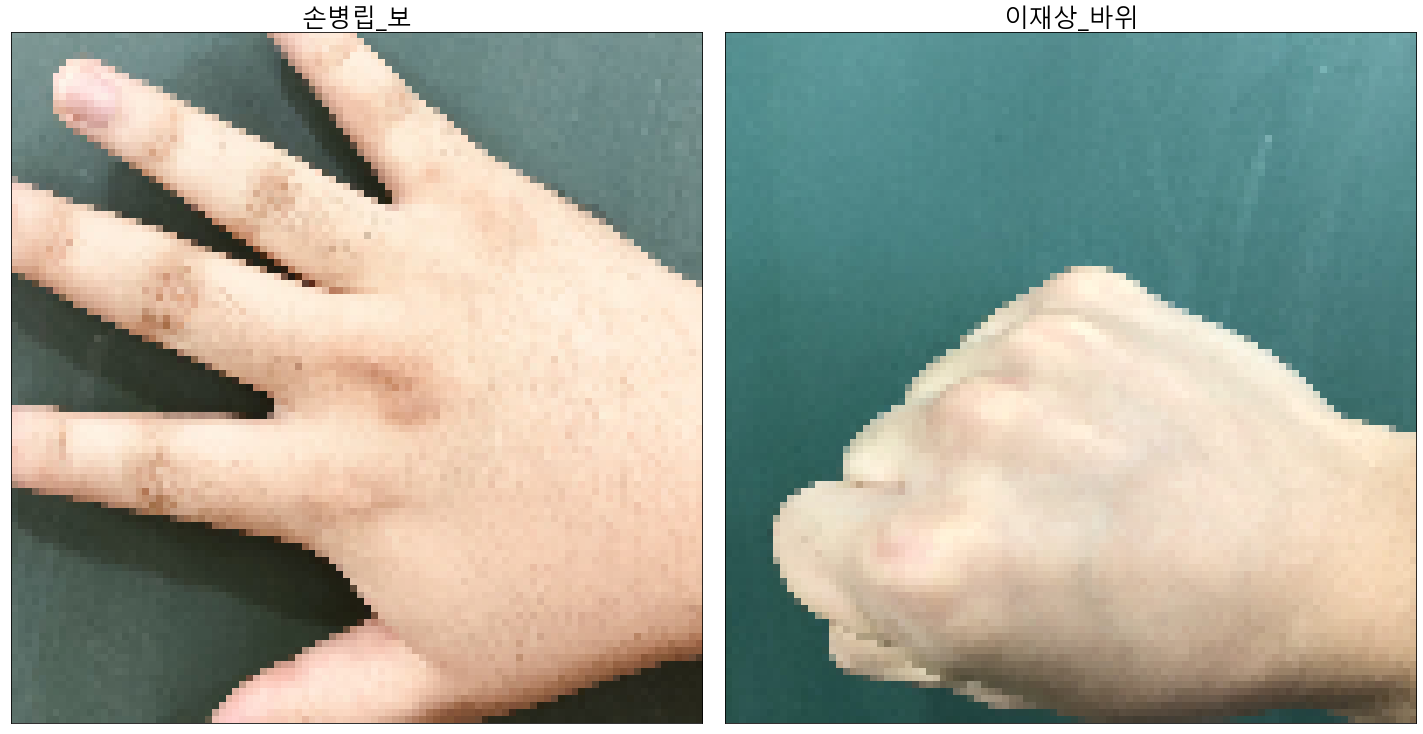

		예측 : [[0. 0. 1.]]							예측 : [[0. 1. 0.]]
							▶ 손병립 win ◀


In [47]:
pre_list=[]  # 파일 담을 리스트
pre_name=[]  # 파일명 담을 리스트

for file in pre:
    im = plt.imread('pre/'+file)
    im = cv2.resize(im, (100, 100))
    pre_list.append(im/255.0)
    pre_name.append(file.split('.')[0])

ran_1, ran_2 = random.sample(range(len(pre_list)), 2)

# ran_1 = random.randint(0, len(pre_list)-1)
# ran_2 = random.randint(0, len(pre_list)-1)

pre_out1 = models.predict(pre_list[ran_1].reshape(-1, 100, 100, 3), verbose='Flase')
pre_out2 = models.predict(pre_list[ran_2].reshape(-1, 100, 100, 3), verbose='Flase')


# 왼쪽 이미지
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title(pre_name[ran_1], fontsize=25)
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(pre_list[ran_1].reshape(100,100,3))

# 오른쪽 이미지
plt.subplot(122)
plt.title(pre_name[ran_2], fontsize=25)
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(pre_list[ran_2].reshape(100,100,3))

plt.tight_layout()
plt.show()

print(f'\t\t예측 : {np.round(pre_out1)}\t\t\t\t\t\t\t예측 : {np.round(pre_out2)}')

if np.round(pre_out1).argmax() == np.round(pre_out2).argmax():
    print(f"\t\t\t\t\t\t▶ {pre_name[ran_1].split('_')[0]} & {pre_name[ran_2].split('_')[0]} draw ◀")
elif np.round(pre_out1).argmax() == 0:
    if np.round(pre_out2).argmax() == 1:
        print(f"\t\t\t\t\t\t\t▶ {pre_name[ran_2].split('_')[0]} win ◀")
    elif np.round(pre_out2).argmax() == 2:
        print(f"\t\t\t\t\t\t\t▶ {pre_name[ran_1].split('_')[0]} win ◀")
elif np.round(pre_out1).argmax() == 1:
    if np.round(pre_out2).argmax() == 0:
        print(f"\t\t\t\t\t\t\t▶ {pre_name[ran_1].split('_')[0]} win ◀")
    elif np.round(pre_out2).argmax()  == 2:
        print(f"\t\t\t\t\t\t\t▶ {pre_name[ran_2].split('_')[0]} win ◀")
elif np.round(pre_out1).argmax() == 2:
    if np.round(pre_out2).argmax() == 0:
        print(f"\t\t\t\t\t\t\t▶ {pre_name[ran_2].split('_')[0]} win ◀")
    elif np.round(pre_out2).argmax() == 1:
        print(f"\t\t\t\t\t\t\t▶ {pre_name[ran_1].split('_')[0]} win ◀")